In [1]:
import numpy as np
import astropy
from itertools import izip
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from pearce.mocks.customHODModels import *
from halotools.utils.table_utils import compute_conditional_percentiles

In [1]:
%%bash
ls ../*.hdf5 -lt

-rw-r--r-- 1 swmclau2 des   28562856 Nov  1 12:15 ../catalog_ab_halo_vmax@mpeak_shuffled.hdf5
-rw-r--r-- 1 swmclau2 des 8061416824 Oct 26 10:16 ../catalog_ab_halo_vmax@mpeak.hdf5


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
shuffle_type = 'sh_shuffled'
mag_type = 'vpeak'

In [4]:
mag_cut = -21
min_ptcl = 200
#mass_key ='halo_mvir'
mag_key = 'halo_%s_%s_mag'%(shuffle_type, mag_type)
#mag_key = 'halo_%s_mag'%mag_type
upid_key = 'halo_%s_upid'%(shuffle_type)
#upid_key = 'halo_upid'

In [5]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')
catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [6]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [7]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)

In [8]:
halo_catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog[mag_key] <=mag_cut)]

In [9]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [10]:
from collections import Counter
def compute_occupations(halo_table, halo_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_table[upid_key] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(halo_catalog[halo_catalog[upid_key]==-1]['halo_id'])
    detected_satellite_upids = Counter(halo_catalog[halo_catalog[upid_key]!=-1][upid_key])
    
    for idx, row  in enumerate(halo_table[halo_table[upid_key] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [11]:
def compute_hod(masses, centrals, satellites, mass_bins):
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = masses)
    mass_bin_nos = set(mass_bin_idxs)

    cens_occ = np.zeros((mass_bins.shape[0]-1,))
    sats_occ = np.zeros_like(cens_occ)

    for mb in mass_bin_nos:
        indices_of_mb = np.where(mass_bin_idxs == mb)[0]
        denom = len(indices_of_mb)
        #TODO what to do about bout 0 mean std's?
        cens_occ[mb-1] = np.mean(centrals[indices_of_mb])
        sats_occ[mb-1] = np.mean(satellites[indices_of_mb])

    return cens_occ, sats_occ

In [12]:
#halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]
halo_table = catalog[catalog['halo_mvir']> min_ptcl*cat.pmass]
cens_occ, sats_occ = compute_occupations(halo_table, halo_catalog)

In [13]:
hod_catalog = np.zeros((np.sum(halo_table[upid_key]==-1), 6))
hod_catalog[:,3] = halo_table[halo_table[upid_key]==-1]['halo_mvir']
hod_catalog[:,1] = cens_occ
hod_catalog[:,2] = sats_occ
hod_catalog[:,5] = halo_table[halo_table[upid_key]==-1]['halo_nfw_conc']

In [14]:
mass_bins = compute_mass_bins(hod_catalog[:,3], 0.1)
mbc = (mass_bins[1:]+mass_bins[:-1])/2.0

In [15]:
cen_hod, sat_hod = compute_hod(hod_catalog[:,3], hod_catalog[:,1], hod_catalog[:,2], mass_bins)

In [16]:
from pearce.mocks.customHODModels import *

In [17]:
cat.load_model(1.0, HOD=(AssembiasTabulatedCens, AssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mbc,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':cen_hod,
                                                               'sat_hod_vals':sat_hod})# ,
                                                                #'split':0.7})

In [18]:
cat.model._haloprop_list

['halo_nfw_conc', 'halo_mvir']

In [19]:
cat.model.param_dict

{'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_slope1': 1.0,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_slope1': 1.0}

In [20]:
#rp_bins = np.logspace(-1,1.5,20)
rp_bins = np.logspace(-1.1,1.6, 18)
bin_centers = (rp_bins[:1]+rp_bins[:-1])/2

In [21]:
out = '['
for r in bin_centers:
    out+=str(r)
    out+=' '
out+=']'
print out

[0.0794328234724 0.0969687902331 0.122247403341 0.158687269437 0.21121641079 0.286938716794 0.396094653458 0.553446154459 0.780272982427 1.10725054259 1.57859833602 2.25806007723 3.23752421009 4.64945063566 6.68478420666 9.61877755803 13.8482154785 ]


In [22]:
np.savetxt('prim_haloprop_vals.npy', mbc)
np.savetxt('cen_hod_vals.npy', cen_hod)
np.savetxt('sat_hod_vals.npy', sat_hod)

In [23]:
%%bash
pwd

/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests


In [24]:
print rp_bins.shape

(18,)


In [25]:
from halotools.mock_observables import wp, tpcf

In [26]:
min_logmass, max_logmass = 9.0, 17.0

In [27]:
from halotools.mock_observables import tpcf_one_two_halo_decomp

In [28]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 0.0, 0.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_no_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_no_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_no_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


In [29]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
#MAP = np.array([ 0.38800666, -0.49540832, 3, 3])
MAP = np.array([1.0, -1.0, 5.0, 3.0])

params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [30]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 1.0, -1.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [31]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 1.0, 0.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_cen_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_cen_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_cen_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [32]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 0.0, -1.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_sat_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_sat_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_sat_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [33]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [34]:
#catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')
#halo_catalog_orig = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vpeak_mag'] <=mag_cut)]
#halo_catalog_orig = catalog[np.logical_and( \
#                       np.logical_and(catalog['halo_shuffled_host_mvir'] > 10**min_logmass,\
#                                      catalog['halo_shuffled_host_mvir'] < 10**max_logmass),\
#                        catalog['halo_vvir_mag'] <=mag_cut)]

mag_cut = catalog['halo_%s_mag'%mag_type] <=mag_cut
cut_idx = catalog['halo_upid'] >= -1
mass_cut = np.logical_and(np.log10(catalog['halo_mvir_host_halo']) > min_logmass,\
                          np.log10(catalog['halo_mvir_host_halo']) <= max_logmass)
mass_cut = np.logical_and(mass_cut, cut_idx)

halo_catalog_orig = catalog[np.logical_and(mag_cut, mass_cut)]

In [35]:
print len(halo_catalog_orig)

59782


In [36]:
centrals_idx = np.where(halo_catalog_orig['halo_upid']>=-1)[0]

sham_pos = np.c_[halo_catalog_orig['halo_x'],\
                 halo_catalog_orig['halo_y'],\
                 halo_catalog_orig['halo_z']]
sham_wp = tpcf(sham_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [37]:
print sham_wp

[  3.05962327e+03   1.51733602e+03   8.84118437e+02   5.10447582e+02
   2.33658760e+02   1.11188314e+02   5.02852205e+01   2.35196619e+01
   1.10573221e+01   5.59306545e+00   3.14374543e+00   1.78636202e+00
   9.85313022e-01   5.24776983e-01   2.78489463e-01   1.34953491e-01
   6.02208621e-02]


In [38]:
host_ids = halo_catalog_orig['halo_upid']
host_ids[centrals_idx] = halo_catalog_orig[centrals_idx]['halo_id']
sham_wp_1h, sham_wp_2h = tpcf_one_two_halo_decomp(sham_pos,host_ids, rp_bins , period=cat.Lbox, num_threads=1)

In [39]:
#sham_nd = len(halo_catalog_orig[centrals_idx])/(cat.Lbox**3)
sham_nd = len(halo_catalog_orig)/(cat.Lbox**3)

In [40]:
sham_nfw_pos = np.c_[halo_catalog_orig['halo_nfw_x'],\
                 halo_catalog_orig['halo_nfw_y'],\
                 halo_catalog_orig['halo_nfw_z']]

sham_nfw_wp = tpcf(sham_nfw_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [41]:
sham_nfw_wp_1h, sham_nfw_wp_2h = tpcf_one_two_halo_decomp(sham_nfw_pos,host_ids,\
                                                          rp_bins, period=cat.Lbox, num_threads=1)

In [42]:
halo_catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [43]:
shuffle_type = 'shuffled'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)

sham_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[ma ss_cut]['halo_%s_z'%shuffle_type]]
sham_shuffled_wp = tpcf(sham_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [44]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_shuffled_wp_1h, sham_shuffled_wp_2h = tpcf_one_two_halo_decomp(sham_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [45]:
shuffle_type = 'sh_shuffled'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [46]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_wp_1h, sham_sh_shuffled_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [47]:
shuffle_type = 'sh_shuffled_cen'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_cen_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [48]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_cen_wp_1h, sham_sh_shuffled_cen_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [49]:
shuffle_type = 'sh_shuffled_sats'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_sat_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [50]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_sat_wp_1h, sham_sh_shuffled_sat_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [51]:
#shuffled_nd = len(cut_idx)/(cat.Lbox**3)
shuffled_nd = len(halo_catalog)/(cat.Lbox**3)

In [52]:
print sham_nd,shuffled_nd, mock_nd
print sham_nd-mock_nd, nd_err
print (sham_nd-mock_nd)/nd_err

0.00093409375 0.00093409375 nan
nan nan
nan


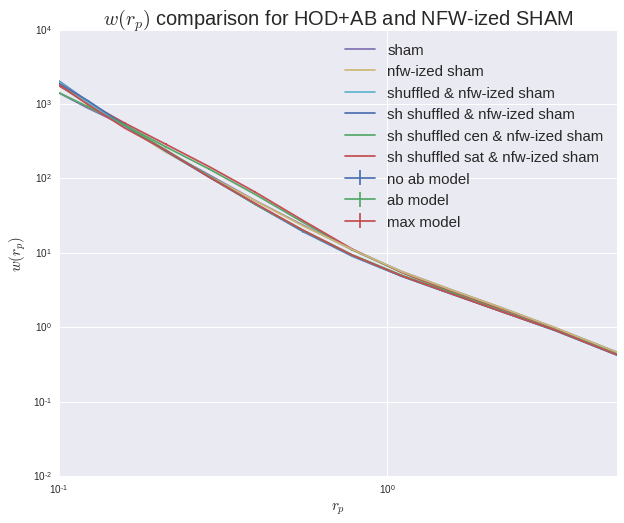

In [53]:
plt.figure(figsize=(10,8))
plt.errorbar(bin_centers, mock_wp_no_ab,yerr=wp_errs, label = 'no ab model')
plt.errorbar(bin_centers, mock_wp_ab,yerr=wp_errs, label = 'ab model')
plt.errorbar(bin_centers, mock_wp_max_ab,yerr=wp_errs, label = 'max model')
plt.plot(bin_centers, sham_wp, label = 'sham')
plt.plot(bin_centers, sham_nfw_wp, label = 'nfw-ized sham')
plt.plot(bin_centers, sham_shuffled_wp, label = 'shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_wp, label = 'sh shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_cen_wp, label = 'sh shuffled cen & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_sat_wp, label = 'sh shuffled sat & nfw-ized sham')


plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ comparison for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [54]:
print sham_sh_shuffled_wp_2h/sham_shuffled_wp_2h

[ 0.84083433  0.9361688   1.05500697  1.04682921  0.99728946  0.99456483
  0.99479369  1.0155265   1.01787088  1.007652    1.00428735  0.98355716
  1.0075423   1.00151759  0.99662921  1.0019775   0.98790069]


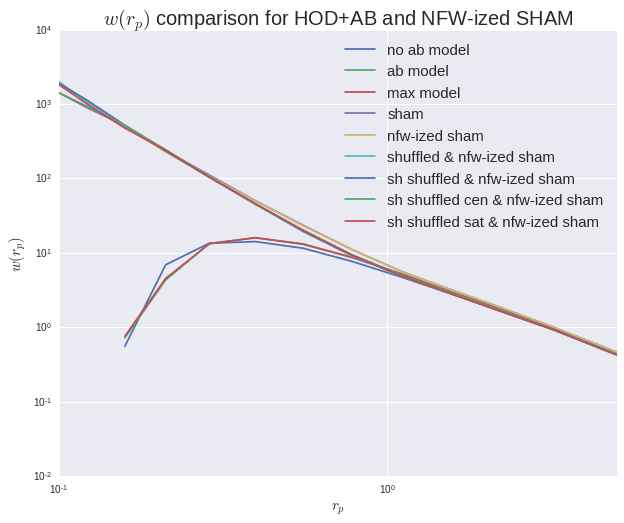

In [55]:
plt.figure(figsize=(10,8))
plt.plot(bin_centers, mock_wp_no_ab_2h, label = 'no ab model')
plt.plot(bin_centers, mock_wp_ab_2h, label = 'ab model')
plt.plot(bin_centers, mock_wp_max_ab_2h, label = 'max model')

plt.plot(bin_centers, sham_wp_2h, label = 'sham')
plt.plot(bin_centers, sham_nfw_wp_2h, label = 'nfw-ized sham')
plt.plot(bin_centers, sham_shuffled_wp_2h, label = 'shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_wp_2h, label = 'sh shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_cen_wp_2h, label = 'sh shuffled cen & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_sat_wp_2h, label = 'sh shuffled sat & nfw-ized sham')

plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ comparison for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [56]:
%%bash
ls *xi*.npy

mock_xi.npy
mock_xi_ab.npy
mock_xi_ab_alpha_05.npy
mock_xi_ab_vpeak.npy
mock_xi_ab_vpeak_1h.npy
mock_xi_ab_vpeak_2h.npy
mock_xi_ab_vvir.npy
mock_xi_alpha_05.npy
mock_xi_max_ab.npy
mock_xi_max_ab2_vpeak.npy
mock_xi_max_ab_alpha_05.npy
mock_xi_max_ab_vpeak.npy
mock_xi_max_ab_vpeak_1h.npy
mock_xi_max_ab_vpeak_2h.npy
mock_xi_max_ab_vvir.npy
mock_xi_max_cen_ab_vpeak.npy
mock_xi_max_cen_ab_vpeak_1h.npy
mock_xi_max_cen_ab_vpeak_2h.npy
mock_xi_max_sat_ab_vpeak.npy
mock_xi_max_sat_ab_vpeak_1h.npy
mock_xi_max_sat_ab_vpeak_2h.npy
mock_xi_vpeak.npy
mock_xi_vpeak_1h.npy
mock_xi_vpeak_2h.npy
mock_xi_vvir.npy
sham_nfw_xi.npy
sham_nfw_xi_alpha_05.npy
sham_nfw_xi_vpeak.npy
sham_nfw_xi_vpeak_1h.npy
sham_nfw_xi_vpeak_2h.npy
sham_nfw_xi_vvir.npy
sham_sh_shuffle_cen_xi_vpeak.npy
sham_sh_shuffle_cen_xi_vpeak_1h.npy
sham_sh_shuffle_cen_xi_vpeak_2h.npy
sham_sh_shuffle_sat_xi_vpeak.npy
sham_sh_shuffle_sat_xi_vpeak_1h.npy
sham_sh_shuffle_sat_xi_vpeak_2h.npy
sham_sh_shuffle_xi_vpeak.npy
sham_sh_shuffle_xi_vpeak_

In [57]:
np.savetxt('mock_xi_%s.npy'%mag_type,mock_wp_no_ab)
np.savetxt('mock_xi_ab_%s.npy'%mag_type,mock_wp_ab)
np.savetxt('mock_xi_max_ab_%s.npy'%mag_type,mock_wp_max_ab)
np.savetxt('mock_xi_max_cen_ab_%s.npy'%mag_type,mock_wp_max_cen_ab)
np.savetxt('mock_xi_max_sat_ab_%s.npy'%mag_type,mock_wp_max_sat_ab)
np.savetxt('sham_xi_%s.npy'%mag_type, sham_wp)
np.savetxt('sham_shuffle_xi_%s.npy'%(mag_type), sham_shuffled_wp)
np.savetxt('sham_sh_shuffle_xi_%s.npy'%(mag_type), sham_sh_shuffled_wp)
np.savetxt('sham_nfw_xi_%s.npy'%mag_type, sham_nfw_wp)
np.savetxt('sham_sh_shuffle_cen_xi_%s.npy'%(mag_type), sham_sh_shuffled_cen_wp)
np.savetxt('sham_sh_shuffle_sat_xi_%s.npy'%(mag_type), sham_sh_shuffled_sat_wp)

In [58]:
np.savetxt('mock_xi_%s_1h.npy'%mag_type,mock_wp_no_ab_1h)
np.savetxt('mock_xi_ab_%s_1h.npy'%mag_type,mock_wp_ab_1h)
np.savetxt('mock_xi_max_ab_%s_1h.npy'%mag_type,mock_wp_max_ab_1h)
np.savetxt('mock_xi_max_cen_ab_%s_1h.npy'%mag_type,mock_wp_max_cen_ab_1h)
np.savetxt('mock_xi_max_sat_ab_%s_1h.npy'%mag_type,mock_wp_max_sat_ab_1h)
np.savetxt('sham_xi_%s_1h.npy'%mag_type, sham_wp_1h)
np.savetxt('sham_shuffle_xi_%s_1h.npy'%(mag_type), sham_shuffled_wp_1h)
np.savetxt('sham_sh_shuffle_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_wp_1h)
np.savetxt('sham_nfw_xi_%s_1h.npy'%mag_type, sham_nfw_wp_1h)
np.savetxt('sham_sh_shuffle_cen_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_cen_wp_1h)
np.savetxt('sham_sh_shuffle_sat_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_sat_wp_1h)

In [59]:
np.savetxt('mock_xi_%s_2h.npy'%mag_type,mock_wp_no_ab_2h)
np.savetxt('mock_xi_ab_%s_2h.npy'%mag_type,mock_wp_ab_2h)
np.savetxt('mock_xi_max_ab_%s_2h.npy'%mag_type,mock_wp_max_ab_2h)
np.savetxt('mock_xi_max_cen_ab_%s_2h.npy'%mag_type,mock_wp_max_cen_ab_2h)
np.savetxt('mock_xi_max_sat_ab_%s_2h.npy'%mag_type,mock_wp_max_sat_ab_2h)
np.savetxt('sham_xi_%s_2h.npy'%mag_type, sham_wp_2h)
np.savetxt('sham_shuffle_xi_%s_2h.npy'%(mag_type), sham_shuffled_wp_2h)
np.savetxt('sham_sh_shuffle_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_wp_2h)
np.savetxt('sham_nfw_xi_%s_2h.npy'%mag_type, sham_nfw_wp_2h)
np.savetxt('sham_sh_shuffle_cen_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_cen_wp_2h)
np.savetxt('sham_sh_shuffle_sat_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_sat_wp_2h)

In [60]:
plt.figure(figsize=(10,8))
plt.errorbar(bin_centers, mock_wp/mock_wp,yerr=wp_errs/mock_wp, label = 'model/model')
plt.plot(bin_centers, sham_wp/mock_wp, label = 'sham/model')
plt.plot(bin_centers, sham_nfw_wp/mock_wp, label = 'nfw-ized sham/model')
plt.plot(bin_centers, sham_shuffled_wp/mock_wp, label = 'shuffled & nfw-ized sham/model')
plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
#plt.ylim([0.8,1.2]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w_{SHAM}(r_p)/w_{HOD+AB}(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ ratio for HOD+AB and NFW-ized SHAM', fontsize = 20)

NameError: name 'mock_wp' is not defined

In [ ]:
print mock_wps/sham_shuffled_wp

In [ ]:
colors = sns.color_palette("coolwarm", ab_vals.shape[0])

In [ ]:
plt.figure(figsize=(10,8))
#plt.errorbar(bin_centers, mock_wp/sham_shuffled_wp,yerr=wp_errs/mock_wp, label = 'model/model')
for mwp, a, c in zip(mock_wps, ab_vals, colors):
    plt.plot(bin_centers,mwp/sham_shuffled_wp, c =c, label = a)
plt.plot(bin_centers, sham_wp/sham_shuffled_wp, label = 'sham/model')
plt.plot(bin_centers, sham_nfw_wp/sham_shuffled_wp, label = 'nfw-ized sham/model')
plt.plot(bin_centers, sham_shuffled_wp/sham_shuffled_wp, label = 'shuffled & nfw-ized sham/model')
plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
#plt.ylim([0.8,1.2]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w_{SHAM}(r_p)/w_{HOD+AB}(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ ratio for HOD+AB and NFW-ized SHAM', fontsize = 20)